In [6]:
!pip install celluloid
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 735 kB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 3.0 MB/s eta 0:00:01


In [7]:
%matplotlib inline
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns  # Fancier plots
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set seaborn plotting style
sns.set_style('darkgrid')

import time

torch.manual_seed(1234)

In [9]:
iris = load_iris()
data = iris.data[iris.target==1,::2]

x_train = torch.FloatTensor(data[:,0:1])
y_train = torch.FloatTensor(data[:,1:2])
n_samples = x_train.shape[0]

In [10]:
xt_min = x_train.min()
xt_max = x_train.max()
x_train_n = (x_train - xt_min)/(xt_max - xt_min)

yt_min = y_train.min()
yt_max = y_train.max()
y_train_n = (y_train - yt_min)/(yt_max - yt_min)

In [11]:
x_train_bias = torch.cat([torch.ones(size=(n_samples,1)),x_train_n],dim=1)

In [12]:
model = torch.nn.Linear(2, 1, bias=False)

In [13]:
model.weight.data

tensor([[-0.6661, -0.1387]])

In [14]:
model(torch.ones(size=(5,2)))

tensor([[-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049]], grad_fn=<MmBackward>)

In [15]:
learning_rate = 0.1

In [16]:
def MSELoss(pred, true,axis=1):
  return ((pred - true)**2).mean(axis=axis)

In [19]:
num_epochs = 100
w_history = []
loss_history = []
out_history = []
for epoch in range(num_epochs):
  inputs = x_train_bias
  target = y_train_n
  out = model(inputs)
  loss = ((out - target)**2).mean()
  loss.backward()
  model.weight.data = model.weight.data - learning_rate * model.weight.grad.data
  model.weight.grad.data.zero_()

  #Armazena valor para gráficos
  w_history.append((model.weight.data[0][0].item(),model.weight.data[0][1].item()))
  loss_history.append(loss.item())
  out_history.append(out)

  #verbose
  if (epoch+1) % 20 == 0:
    print('Epoch[{}/{}] - loss: {:.6f}'.format(epoch+1,num_epochs,loss.item()))

Epoch[20/100] - loss: 0.021239
Epoch[40/100] - loss: 0.021217
Epoch[60/100] - loss: 0.021202
Epoch[80/100] - loss: 0.021192
Epoch[100/100] - loss: 0.021185


In [21]:
x = x_train_bias
y = y_train_n
w_opt = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x.T,x)),x.T),y) # w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
nb_of_ws = 100 # Verifica a loss nb_of_ws vezes em cada dimensão
wsa = np.linspace(-1, 1, num=nb_of_ws)  
wsb = np.linspace(-1, 1, num=nb_of_ws)
ws_x, ws_y = np.meshgrid(wsa, wsb)
ws_x = torch.Tensor(np.expand_dims(ws_x, axis=-1))
ws_y = torch.Tensor(np.expand_dims(ws_y, axis=-1))
yp = ws_x + ws_y*x_train_n.reshape(-1) # Calcula w0 e w1 para todos os calores da matriz

loss_grid = MSELoss(yp, y_train_n.reshape(-1), axis=-1) # Calcula a loss

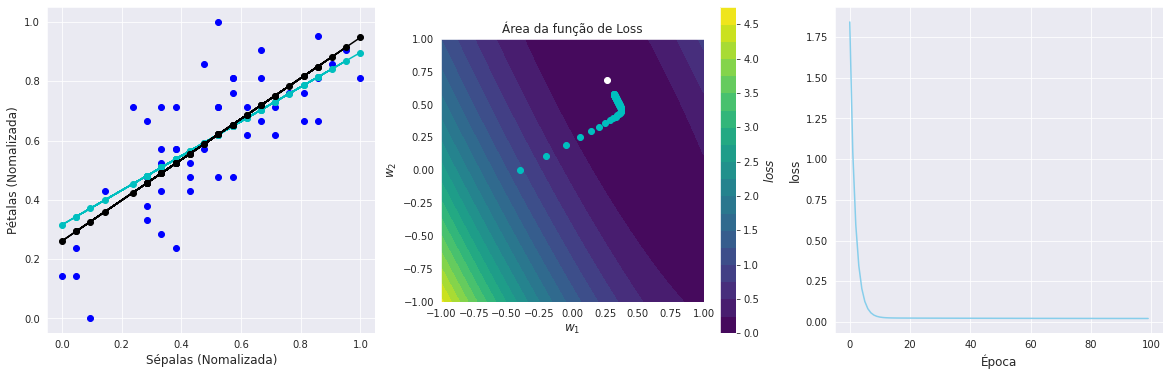

In [ ]:
#Estático


fig = plt.figure(figsize=(20, 6))

# 1º Gráfico:
y_opt = w_opt[0,0].item() + x_train_n * w_opt[1,0].item()
y_pred = model(x_train_bias)

ax1 = fig.add_subplot(131)
CS1 = plt.scatter(x_train_n.reshape(-1),y_train_n.reshape(-1),color='blue')
ax1.plot(x_train_n, y_pred.detach().numpy(), 'co-', label='Fitting Line')
ax1.plot(x_train_n, y_opt, 'ko-', label='Fitting Line')
ax1.set_xlabel('Sépalas (Nomalizada)', fontsize=12)
ax1.set_ylabel('Pétalas (Nomalizada)', fontsize=12)

# ----------------------------

ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
CS2 = plt.contourf(wsa, wsb, loss_grid, 20, cmap=cm.viridis)

divider = make_axes_locatable(ax2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$loss$', fontsize=12)
ax2.plot(w_opt[0,0],w_opt[1,0],'wo')

for i in range(len(w_history)):
  w_lo = w_history[i]
  ax2.plot(w_lo[0],w_lo[1],'co')
ax2.set_xlabel('$w_1$', fontsize=12)
ax2.set_ylabel('$w_2$', fontsize=12)
ax2.set_title('Área da função de Loss')


ax3 = fig.add_subplot(133)
CS3 = sns.lineplot(data=loss_history,color='skyblue')
ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('loss', fontsize=12)

divider = make_axes_locatable(ax3)


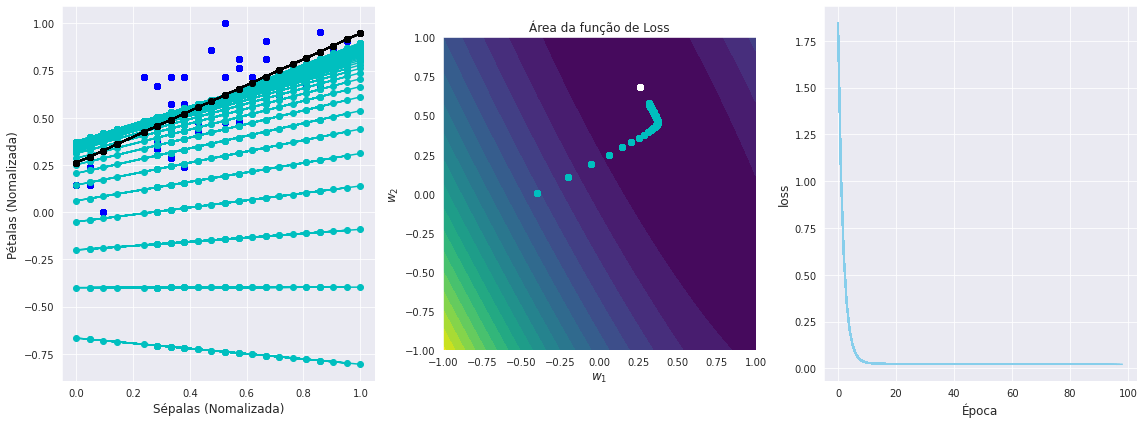

In [ ]:
from celluloid import Camera

fig = plt.figure(figsize=(16, 6))
camera = Camera(fig)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

y_opt = w_opt[0,0].item() + x_train_n * w_opt[1,0].item()

w_animation_part = []
for i in range(num_epochs):

  # 1º Graphic
  # y_pred = model(x_train_bias)

  ax1.scatter(x_train_n.reshape(-1),y_train_n.reshape(-1),color='blue')

  ax1.plot(x_train_n, out_history[i].detach().numpy(), 'co-', label='Fitting Line')

  ax1.plot(x_train_n, y_opt, 'ko-', label='Fitting Line')
  ax1.set_xlabel('Sépalas (Nomalizada)', fontsize=12)
  ax1.set_ylabel('Pétalas (Nomalizada)', fontsize=12)

  # 2º Graphic
  CS2 = ax2.contourf(wsa, wsb, loss_grid, 20, cmap=cm.viridis) #plot da área
  ax2.plot(w_opt[0,0],w_opt[1,0],'wo')  # plot ponto ideal
  ax2.set_aspect('equal')
  w_lo = w_history[i]

  w_animation_part.append(w_lo)
  for j in range(len(w_animation_part)):
    ax2.plot(w_animation_part[j][0],w_animation_part[j][1],'co')
  ax2.set_xlabel('$w_1$', fontsize=12)
  ax2.set_ylabel('$w_2$', fontsize=12)
  ax2.set_title('Área da função de Loss')

  # 3º Graphic
  ax3 = sns.lineplot(data=loss_history[:i],color='skyblue')
  ax3.set_xlabel('Época', fontsize=12)
  ax3.set_ylabel('loss', fontsize=12)

  plt.tight_layout()
  camera.snap()

In [ ]:
animation = camera.animate()

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())